In [1]:
import matplotlib.pyplot as plt
import requests
import pandas as pd
import numpy as np
import csv
import os
import json
import scipy.stats as st
from numpy import array
from scipy.stats import sem
import datetime as dt
from datetime import datetime
import math
import matplotlib.animation as animation
import bar_chart_race as bcr


In [2]:
#Querying the API to get the covid information
Url = "https://api.covidtracking.com/v1/states/daily.json"
Covid_Info_Response = requests.get(Url)
Covid_Info_Json = Covid_Info_Response.json()
Df = pd.read_json(Url)

#Drop the columns that are not needed
Covid_Info_Df=Df.drop(Df.columns[[3,4,5,6,7,9,11,13,14,15,16,17,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,43,45,46,49,50,51,52,53,54,55]], axis=1)


#Drop the data from before Mar, 2020
Covid_Info_Df.drop(Covid_Info_Df.index[20588:] ,axis = 0, inplace=True)
Covid_Info_Df

#Drop the rows that have AS, GU, PR, VI, MP as states
Covid_Info_Df = Covid_Info_Df.drop(Covid_Info_Df[(Covid_Info_Df.state == 'AS') | (Covid_Info_Df.state == 'GU') | (Covid_Info_Df.state == 'PR') | (Covid_Info_Df.state == 'VI') | (Covid_Info_Df.state == 'MP')].index)
Covid_Info_Df.head()


,date,state,positive,hospitalizedCurrently,inIcuCurrently,onVentilatorCurrently,death,hospitalized,positiveIncrease,negativeIncrease,totalTestResultsIncrease,deathIncrease,hospitalizedIncrease
0,20210307,AK,56886.0,33.0,NaN,2.0,305.0,1293.0,0,0,0,0,0
1,20210307,AL,499819.0,494.0,NaN,NaN,10148.0,45976.0,408,2087,2347,-1,0
2,20210307,AR,324818.0,335.0,141.0,65.0,5319.0,14926.0,165,3267,3380,22,11
4,20210307,AZ,826454.0,963.0,273.0,143.0,16328.0,57907.0,1335,13678,45110,5,44
5,20210307,CA,3501394.0,4291.0,1159.0,NaN,54124.0,NaN,3816,0,133186,258,0


In [3]:
#Converting Date into proper format
Covid_Info_Df['date'] = pd.to_datetime(Covid_Info_Df['date'], format='%Y%m%d', errors='ignore')
Covid_Info_Df.head()


,date,state,positive,hospitalizedCurrently,inIcuCurrently,onVentilatorCurrently,death,hospitalized,positiveIncrease,negativeIncrease,totalTestResultsIncrease,deathIncrease,hospitalizedIncrease
0,2021-03-07,AK,56886.0,33.0,NaN,2.0,305.0,1293.0,0,0,0,0,0
1,2021-03-07,AL,499819.0,494.0,NaN,NaN,10148.0,45976.0,408,2087,2347,-1,0
2,2021-03-07,AR,324818.0,335.0,141.0,65.0,5319.0,14926.0,165,3267,3380,22,11
4,2021-03-07,AZ,826454.0,963.0,273.0,143.0,16328.0,57907.0,1335,13678,45110,5,44
5,2021-03-07,CA,3501394.0,4291.0,1159.0,NaN,54124.0,NaN,3816,0,133186,258,0


In [4]:
#Splitting the Date by Year, Month and Day. Also, Renaming the columns
Covid_Info_Df[['year','month','day']] = Covid_Info_Df.date.apply(lambda x: pd.Series(x.strftime("%Y,%m,%d").split(",")))
Covid_Info_Df = Covid_Info_Df.rename(columns={
    "date":"Date", 
    "state":"State", 
    "positive": "Positive(all)",
    "deathIncrease":"Death_Increase",
    "hospitalizedIncrease":"Hospitalized_Increase",
    "hospitalizedCurrently":"Hospitalized_Currently",
    "positiveIncrease":"Positive_Increase",
    "negativeIncrease":"Negative Cases",
    "onVentilatorCurrently":"Ventilator_Currently", 
    "totalTestResultsIncrease":"TotalTestResults",
    "inIcuCurrently":"ICU_Currently",
    "death":"Deaths(all)",
    "hospitalized":"Hospitalized(all)",
    "year":"Year",
    "month":"Month",
    "day":"Day"
})
Covid_Info_Df.head(10)

,Date,State,Positive(all),Hospitalized_Currently,ICU_Currently,Ventilator_Currently,Deaths(all),Hospitalized(all),Positive_Increase,Negative Cases,TotalTestResults,Death_Increase,Hospitalized_Increase,Year,Month,Day
0,2021-03-07,AK,56886.0,33.0,NaN,2.0,305.0,1293.0,0,0,0,0,0,2021,03,07
1,2021-03-07,AL,499819.0,494.0,NaN,NaN,10148.0,45976.0,408,2087,2347,-1,0,2021,03,07
2,2021-03-07,AR,324818.0,335.0,141.0,65.0,5319.0,14926.0,165,3267,3380,22,11,2021,03,07
4,2021-03-07,AZ,826454.0,963.0,273.0,143.0,16328.0,57907.0,1335,13678,45110,5,44,2021,03,07
5,2021-03-07,CA,3501394.0,4291.0,1159.0,NaN,54124.0,NaN,3816,0,133186,258,0,2021,03,07
6,2021-03-07,CO,436602.0,326.0,NaN,NaN,5989.0,23904.0,840,0,38163,3,18,2021,03,07
7,2021-03-07,CT,285330.0,428.0,NaN,NaN,7704.0,NaN,0,0,0,0,0,2021,03,07
8,2021-03-07,DC,41419.0,150.0,38.0,16.0,1030.0,NaN,146,0,5726,0,0,2021,03,07
9,2021-03-07,DE,88354.0,104.0,13.0,NaN,1473.0,NaN,215,917,5867,9,0,2021,03,07
10,2021-03-07,FL,1909209.0,3307.0,NaN,NaN,32266.0,82237.0,4024,19166,64599,66,92,2021,03,07


In [5]:
#Grouping the covid information by Year, Month and State. This helps us to summarize the covid information by Year+Month for each state.
Grouped_Covid_Info_Df = Covid_Info_Df.groupby(['Year','Month','State']).agg({"Positive(all)":'sum',
                                                                  "Hospitalized_Currently":'sum',
                                                                  "Hospitalized_Increase":'sum',
                                                                  "Hospitalized(all)":'sum',
                                                                  "Positive_Increase":'sum',
                                                                  "Ventilator_Currently":'sum',
                                                                  "Deaths(all)":'sum',
                                                                  "ICU_Currently":'sum',
                                                                  "Death_Increase":'sum',
                                                                   "Negative Cases":"sum",
                                                                   "TotalTestResults":"sum"
                                                                    })
Grouped_Covid_Info_Graphs_Df = Grouped_Covid_Info_Df.reset_index()
Grouped_Covid_Info_Df = Grouped_Covid_Info_Df.reset_index()
Grouped_Covid_Info_Df.head()


,Year,Month,State,Positive(all),Hospitalized_Currently,Hospitalized_Increase,Hospitalized(all),Positive_Increase,Ventilator_Currently,Deaths(all),ICU_Currently,Death_Increase,Negative Cases,TotalTestResults
0,2020,03,AK,789.0,0.0,12,72.0,128,0.0,13.0,0.0,3,0,3705
1,2020,03,AL,5640.0,1003.0,0,0.0,981,0.0,30.0,0.0,13,6298,7279
2,2020,03,AR,3759.0,376.0,0,0.0,523,111.0,34.0,0.0,8,5953,6476
3,2020,03,AZ,7133.0,0.0,530,3927.0,1287,0.0,113.0,0.0,24,18055,27966
4,2020,03,CA,45262.0,5863.0,0,0.0,7429,0.0,910.0,2274.0,153,21310,28739


In [6]:
#Retrieving the hospital information from a csv file and drop the columns that are not needed.
Hospital_info_path = "../COVID-19-impact-on-Hospital-systems/Hospital data.csv"
Hospital_Data= pd.read_csv(Hospital_info_path)
Hospital_Data_Df = pd.DataFrame(Hospital_Data)
Hospital_Data_Df=Hospital_Data_Df.drop(Hospital_Data_Df.columns[[3]], axis=1)

Hospital_Data_Df.head()

,State,Number_Hospitals,Staff_Beds
0,AK,10,1274
1,AL,90,15127
2,AR,51,8011
3,AS,1,0
4,AZ,78,13774


In [7]:
#Merging the Grouped Covid info with Hospital information to get the final clean dataset.
Clean_Covid_Data_Df = pd.merge(Grouped_Covid_Info_Df,Hospital_Data_Df)
Clean_Covid_Data_Df.head()

,Year,Month,State,Positive(all),Hospitalized_Currently,Hospitalized_Increase,Hospitalized(all),Positive_Increase,Ventilator_Currently,Deaths(all),ICU_Currently,Death_Increase,Negative Cases,TotalTestResults,Number_Hospitals,Staff_Beds
0,2020,03,AK,789.0,0.0,12,72.0,128,0.0,13.0,0.0,3,0,3705,10,1274
1,2020,04,AK,8290.0,386.0,26,946.0,227,0.0,230.0,0.0,6,0,15406,10,1274
2,2020,05,AK,12268.0,379.0,12,1378.0,108,5.0,305.0,0.0,1,0,32576,10,1274
3,2020,06,AK,20522.0,422.0,18,1784.0,481,39.0,351.0,0.0,4,0,60490,10,1274
4,2020,07,AK,55751.0,952.0,83,3262.0,2049,46.0,558.0,0.0,9,0,120921,10,1274


In [8]:
#Calculate the total number of Positive cases, negative cases, ICU cases, and deaths for each state.
Grouped_Covid_Info_Df = Grouped_Covid_Info_Df.groupby(['State']).agg({"Positive_Increase":'sum',"Negative Cases":'sum',"Ventilator_Currently":'sum',"TotalTestResults":'sum',"Death_Increase":'sum',"Hospitalized_Increase":'sum',"ICU_Currently":'sum'})
Grouped_Covid_Info_Df = Grouped_Covid_Info_Df.reset_index()
Clean_Covid_Hosp_Df= pd.merge(Grouped_Covid_Info_Df,Hospital_Data_Df)
Clean_Covid_Hosp_Df


,State,Positive_Increase,Negative Cases,Ventilator_Currently,TotalTestResults,Death_Increase,Hospitalized_Increase,ICU_Currently,Number_Hospitals,Staff_Beds
0,AK,56886,0,2101.0,1731620,305,1293,0.0,10,1274
1,AL,499819,1931711,0.0,2323788,10148,45976,0.0,90,15127
2,AR,324818,2480710,34700.0,2736436,5319,14926,52440.0,51,8011
3,AZ,826452,3072983,112235.0,7908072,16328,57903,172806.0,78,13774
4,CA,3501341,-462,0.0,49645499,54124,0,668693.0,339,73849
5,CO,436600,2199439,0.0,6415123,5989,23904,0.0,58,8314
6,CT,285330,0,0.0,6520363,7704,0,0.0,35,8860
7,DC,41419,0,9650.0,1261357,1030,0,15628.0,7,2179
8,DE,88354,545060,0.0,1431942,1473,0,6818.0,8,2036
9,FL,1909209,9339038,0.0,22339167,32266,82237,0.0,218,56410


In [9]:
#Generate a summary statistics table consisting of the mean, median, variance, standard deviation, and SEM of the Covid positive cases for each state.

# Use groupby and summary statistical methods to calculate the following properties of each State: 
Cases_group = Clean_Covid_Data_Df.groupby('State')

# mean, median, variance, standard deviation, and SEM of the Positive cases. 
Positive_Mean = Cases_group.mean()
Positive_Mean = Positive_Mean['Positive_Increase']

Positive_Median = Cases_group.median()
Positive_Median = Positive_Median['Positive_Increase']

Positive_std = Cases_group.std()
Positive_std = Positive_std['Positive_Increase']

Positive_var = Cases_group.var()
Positive_var = Positive_var['Positive_Increase']

Positive_sem = Covid_Info_Df.groupby('State').agg(['mean','sem'])
Positive_sem = Positive_sem['Positive_Increase']['sem']
Positive_sem

# Assemble the resulting series into a single summary dataframe.
Summary_Statistics_Dict = {'Mean of Positive Cases':Positive_Mean, 'Median of Positive Cases':Positive_Median, 'Variance of Positive Cases': Positive_var, 'Std of Positive Cases': Positive_std, 'Sem of Positive Cases': Positive_sem}
Summary_Statistics_DF = pd.DataFrame(Summary_Statistics_Dict)
pd.options.display.float_format = '{:20,.2f}'.format

Summary_Statistics_DF.head()

,Mean of Positive Cases,Median of Positive Cases,Variance of Positive Cases,Std of Positive Cases,Sem of Positive Cases
State,,,,,
AK,"4,375.85",2293,"28,516,230.47","5,340.06",10.18
AL,"38,447.62",33613,"1,177,242,076.42","34,310.96",63.52
AR,"24,986.00",21734,"543,777,467.33","23,319.04",45.59
AZ,"63,573.23",27825,"5,511,433,441.03","74,239.03",137.93
CA,"269,333.92",118149,"117,981,890,539.91","343,484.92",615.31


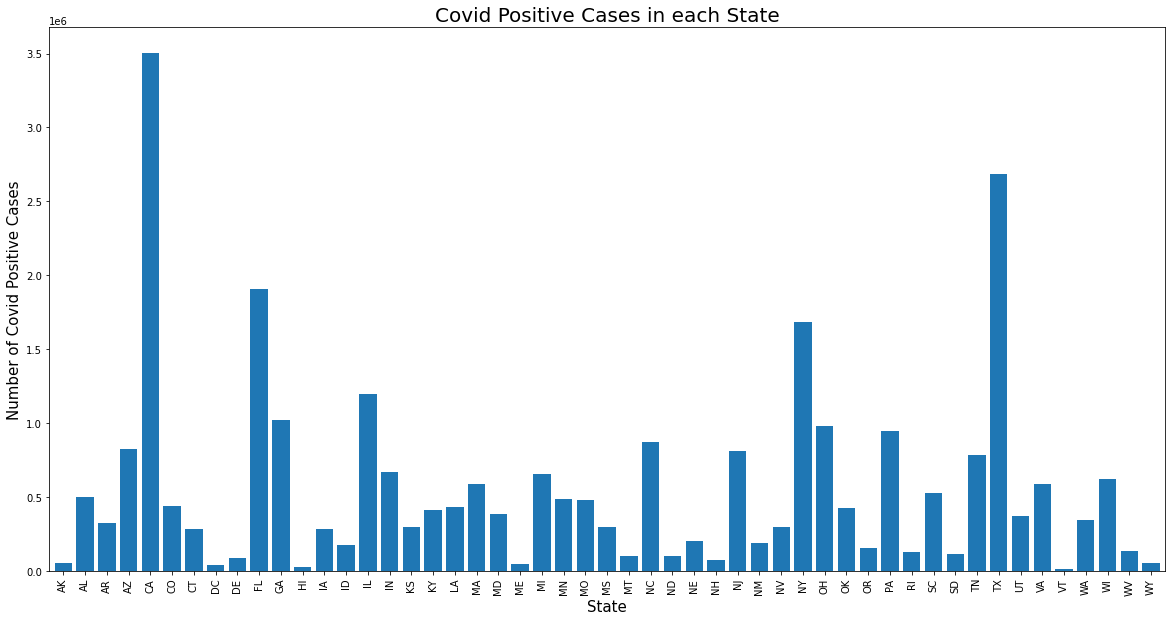

,Positive_Increase
State,
AK,56886
AL,499819
AR,324818
AZ,826452
CA,3501341


<Figure size 432x288 with 0 Axes>

In [13]:
#Generate a bar plot showing the total number of Covid positive cases across all states using pandas.
#y-axis values are multiplied by *1M
Barplot_df = Clean_Covid_Hosp_Df[['State','Positive_Increase']]
Barplot_df = Barplot_df.set_index("State")

Barplot_df.plot(kind="bar", figsize=(20,10), legend=False, width = 0.8)
plt.title("Covid Positive Cases in each State",{'fontsize':20})
plt.ylabel("Number of Covid Positive Cases",{'fontsize':15})
plt.xlabel("State",{'fontsize':15})
plt.show()
plt.tight_layout()
Barplot_df.head()

Text(0.5, 1.0, 'Positive cases in each state')

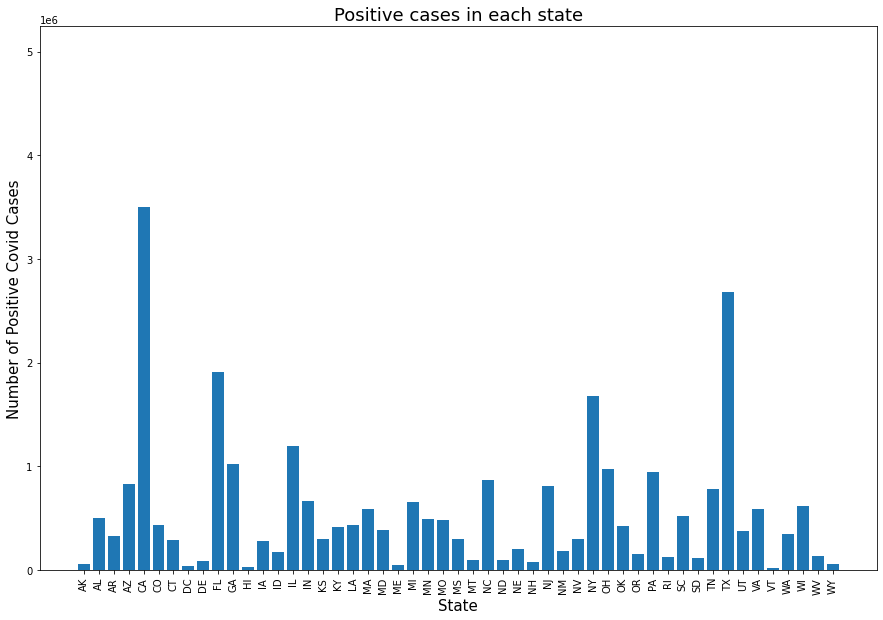

In [14]:
#Generate a bar plot showing the total number of Covid positive cases across all states using pyplot.
x_axis = np.arange(len(Barplot_df))
tick_locations = [value for value in x_axis]
plt.figure(figsize=(15,10))
low = min(Barplot_df['Positive_Increase'])
high = max(Barplot_df['Positive_Increase'])
plt.ylim([0, math.ceil(high+0.5*(high-low))])
plt.bar(x_axis, Barplot_df['Positive_Increase'], alpha=1.0, align="center", width = 0.8)
plt.xticks(tick_locations,Barplot_df.index.values,  rotation="vertical")
plt.xlabel("State", size=15)
plt.ylabel("Number of Positive Covid Cases", size=15)
plt.title("Positive cases in each state", size=18)



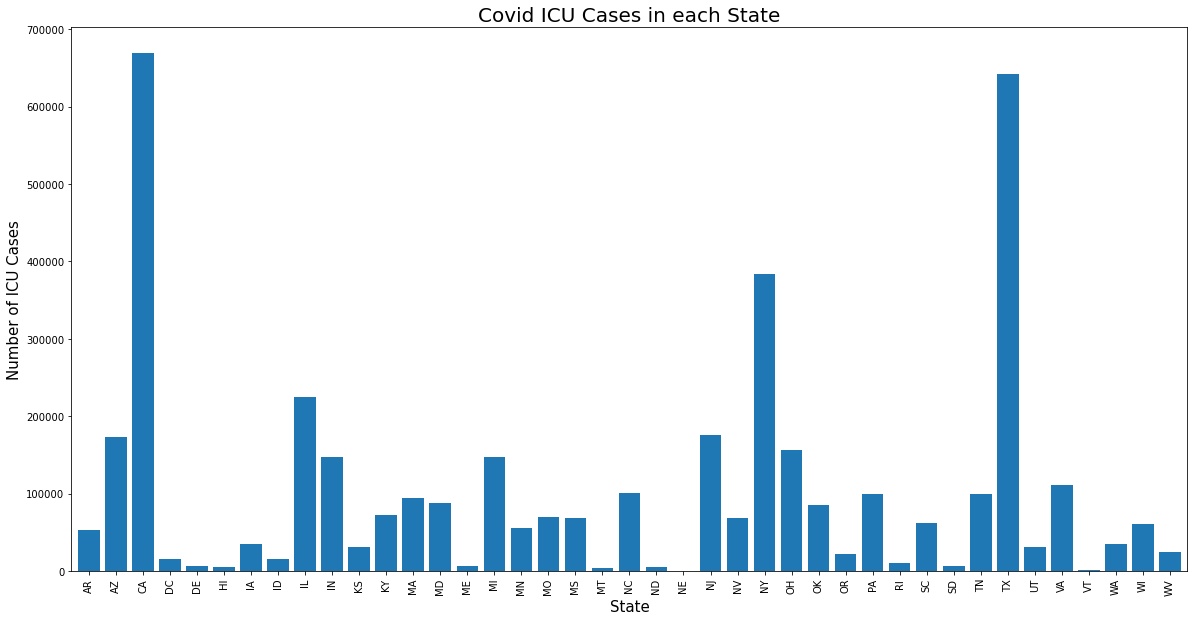

,ICU_Currently
State,
AR,"52,440.00"
AZ,"172,806.00"
CA,"668,693.00"
DC,"15,628.00"
DE,"6,818.00"
HI,"5,431.00"
IA,"35,438.00"
ID,"15,102.00"
IL,"225,442.00"


<Figure size 432x288 with 0 Axes>

In [33]:
#Generate a bar plot showing the total number of ICU cases, Hospital beds for each month across all states

Barplot_ICU_df = Clean_Covid_Hosp_Df[['State','ICU_Currently']]
Barplot_ICU_df = Barplot_ICU_df.set_index("State")
#Barplot_ICU_df = Barplot_ICU_df.loc[(Barplot_ICU_df['ICU_Currently'] != 0.00)
Barplot_ICU_df = Barplot_ICU_df.drop(Barplot_ICU_df[Barplot_ICU_df.ICU_Currently == 0.00].index)
Barplot_ICU_df.plot(kind="bar", figsize=(20,10), legend=False, width = 0.8)
plt.title("Covid ICU Cases in each State",{'fontsize':20})
plt.ylabel("Number of ICU Cases",{'fontsize':15})
plt.xlabel("State",{'fontsize':15})
plt.show()
plt.tight_layout()
Barplot_ICU_df


In [17]:
Grouped_Covid_Timeline_Df = Clean_Covid_Data_Df.groupby(['Year','Month']).agg({"Positive_Increase":'sum',"Negative Cases":'sum',"Ventilator_Currently":'sum',"TotalTestResults":'sum',"Death_Increase":'sum',"Hospitalized_Increase":'sum'})
Grouped_Covid_Timeline_Df = Grouped_Covid_Timeline_Df.reset_index()

Grouped_Covid_Timeline_Df

,Year,Month,Positive_Increase,Negative Cases,Ventilator_Currently,TotalTestResults,Death_Increase,Hospitalized_Increase
0,2020,03,196520,458212,"2,496.00",1174190,4315,6696
1,2020,04,875438,1832032,"136,176.00",5490850,55223,38399
2,2020,05,717818,4109832,"159,218.00",11451542,41091,73150
3,2020,06,831099,5629667,"82,683.00",16619045,19458,31513
4,2020,07,1895445,7552639,"72,562.00",25651159,25181,63101
5,2020,08,1445953,7112974,"73,122.00",25464201,30018,61146
6,2020,09,1182848,6667222,"49,880.00",27503749,23057,37446
7,2020,10,1879604,7502745,"57,416.00",36534605,23353,53485
8,2020,11,4455231,9205551,"126,496.00",48085830,36746,92675
9,2020,12,6298552,8124049,"231,094.00",55733109,76705,126244


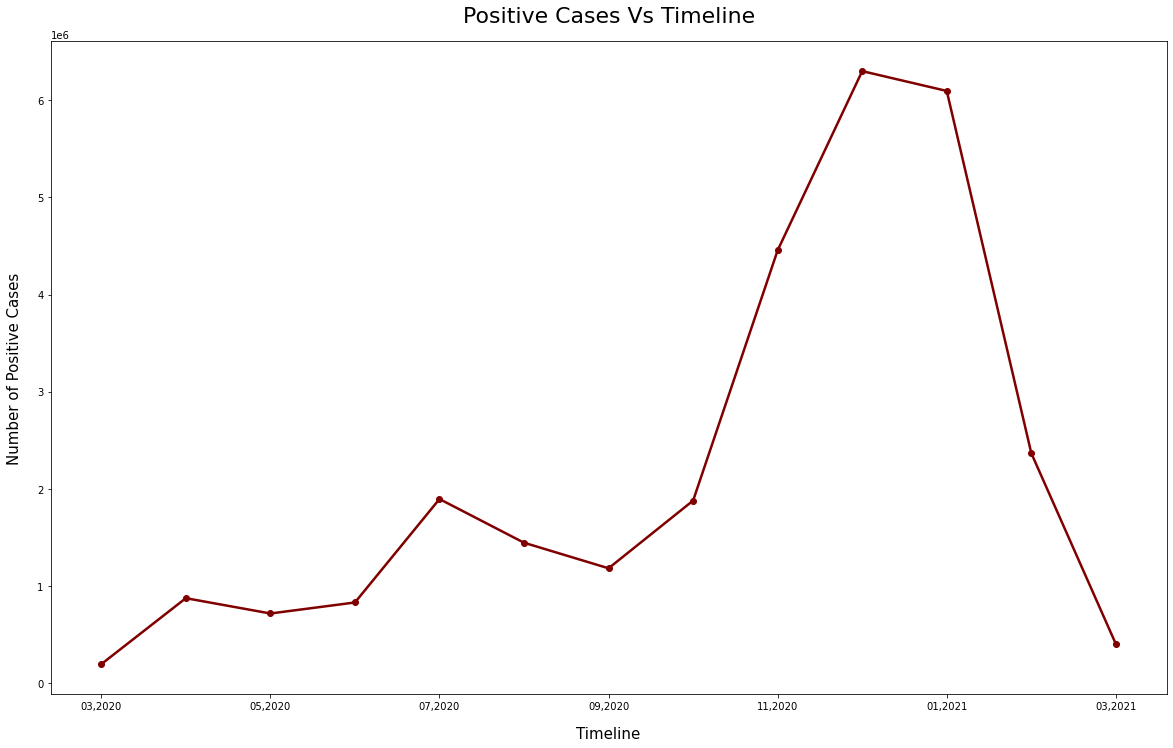

In [18]:
Grouped_Covid_Timeline_Df['Timeline'] = Grouped_Covid_Timeline_Df.Month + ',' + Grouped_Covid_Timeline_Df.Year
Grouped_Covid_Timeline_Df.set_index('Timeline')['Positive_Increase'].plot(figsize=(20, 12), linewidth=2.5, color='maroon', marker='o')
plt.xlabel("Timeline", labelpad=15,fontsize=15)
plt.ylabel("Number of Positive Cases", labelpad=15, fontsize=15)
plt.title("Positive Cases Vs Timeline", y=1.02, fontsize=22);

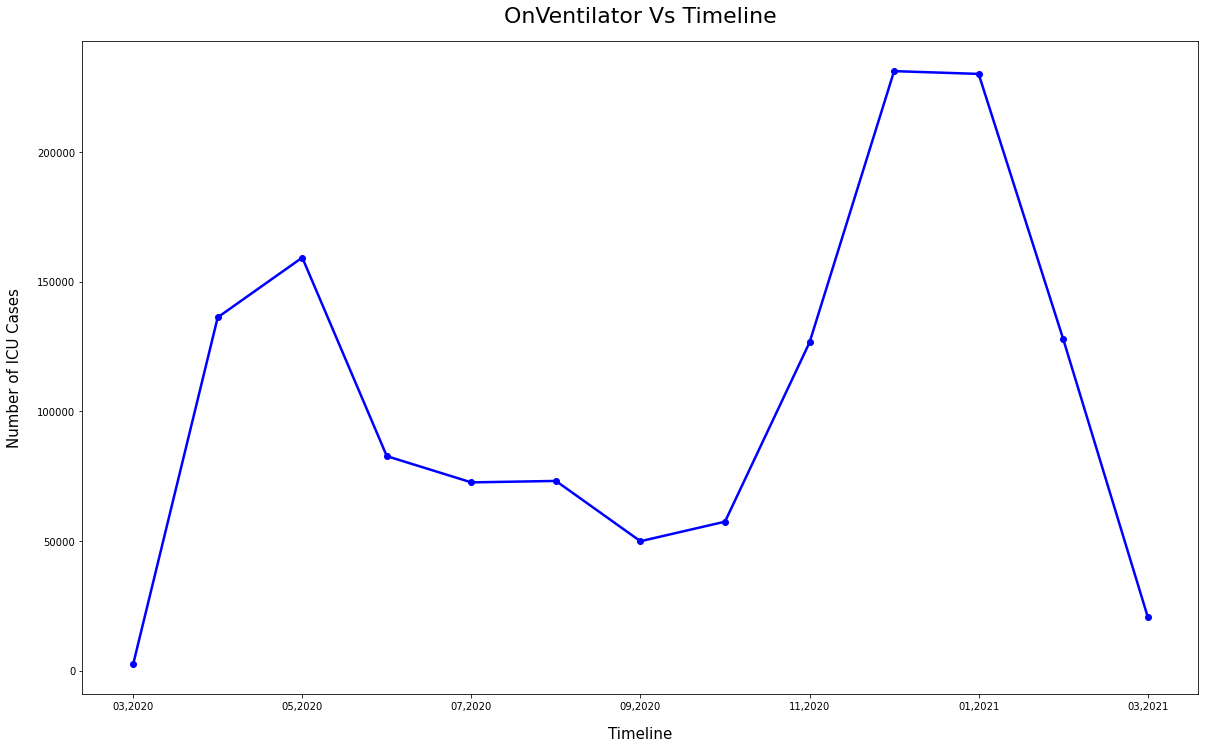

In [19]:
Grouped_Covid_Timeline_Df['Timeline'] = Grouped_Covid_Timeline_Df.Month + ',' + Grouped_Covid_Timeline_Df.Year
Grouped_Covid_Timeline_Df.set_index('Timeline')['Ventilator_Currently'].plot(figsize=(20, 12), linewidth=2.5, color='blue', marker='o')
plt.xlabel("Timeline", labelpad=15,fontsize=15)
plt.ylabel("Number of ICU Cases", labelpad=15, fontsize=15)
plt.title("OnVentilator Vs Timeline", y=1.02, fontsize=22);

In [20]:
death_percent = Grouped_Covid_Timeline_Df['Death_Increase']/Grouped_Covid_Timeline_Df['Positive_Increase']
death_percent_df = pd.DataFrame(death_percent) 
death_percent_df = death_percent_df.rename(columns={0:"Death percentage of Positive Cases"})

positive_percent = Grouped_Covid_Timeline_Df['Positive_Increase']/Grouped_Covid_Timeline_Df['TotalTestResults']
positive_percent_df = pd.DataFrame(positive_percent) 
positive_percent_df = positive_percent_df.rename(columns={0:"Positive Case percentage"})

ICU_percent = Grouped_Covid_Timeline_Df['Ventilator_Currently']/Grouped_Covid_Timeline_Df['Positive_Increase']
ICU_percent_df = pd.DataFrame(ICU_percent) 
ICU_percent_df = ICU_percent_df.rename(columns={0:"ICU percentage of Positive Cases"})



In [21]:
Grouped_Covid_Timeline_Df_Positve_percent = pd.merge(Grouped_Covid_Timeline_Df, positive_percent_df,left_index=True, right_index=True)
Grouped_Covid_Timeline_Df_Positve_percent

,Year,Month,Positive_Increase,Negative Cases,Ventilator_Currently,TotalTestResults,Death_Increase,Hospitalized_Increase,Timeline,Positive Case percentage
0,2020,03,196520,458212,"2,496.00",1174190,4315,6696,"03,2020",0.17
1,2020,04,875438,1832032,"136,176.00",5490850,55223,38399,"04,2020",0.16
2,2020,05,717818,4109832,"159,218.00",11451542,41091,73150,"05,2020",0.06
3,2020,06,831099,5629667,"82,683.00",16619045,19458,31513,"06,2020",0.05
4,2020,07,1895445,7552639,"72,562.00",25651159,25181,63101,"07,2020",0.07
5,2020,08,1445953,7112974,"73,122.00",25464201,30018,61146,"08,2020",0.06
6,2020,09,1182848,6667222,"49,880.00",27503749,23057,37446,"09,2020",0.04
7,2020,10,1879604,7502745,"57,416.00",36534605,23353,53485,"10,2020",0.05
8,2020,11,4455231,9205551,"126,496.00",48085830,36746,92675,"11,2020",0.09
9,2020,12,6298552,8124049,"231,094.00",55733109,76705,126244,"12,2020",0.11


In [ ]:
Grouped_Covid_Timeline_Df_Positve_percent['Timeline'] = Grouped_Covid_Timeline_Df.Month + ',' + Grouped_Covid_Timeline_Df.Year
Grouped_Covid_Timeline_Df_Positve_percent.set_index('Timeline')['Positive Case percentage'].plot(figsize=(20, 12), linewidth=2.5, color='maroon', marker='o')

plt.xlabel("Timeline", labelpad=15,fontsize=15)
plt.ylabel("Number of Positive Cases percentage", labelpad=15, fontsize=15)
plt.title("Positive Cases Vs Timeline", y=1.02, fontsize=22);

In [ ]:
Grouped_Covid_Timeline_Df_Positve_and_ICU_percent = pd.merge(Grouped_Covid_Timeline_Df_Positve_percent, ICU_percent_df,left_index=True, right_index=True)
Grouped_Covid_Timeline_Df_Positve_and_ICU_percent.style.format({'Positive Case percentage':'{:.2%}','ICU percentage of Positive Cases':"{:.2%}"})

In [ ]:
Grouped_Covid_Timeline_Df_Positve_and_ICU_percent_and_deaths = pd.merge(Grouped_Covid_Timeline_Df_Positve_and_ICU_percent, death_percent_df,left_index=True, right_index=True)
Grouped_Covid_Timeline_Df_Positve_and_ICU_percent_and_deaths
Grouped_Covid_Timeline_Df_Positve_and_ICU_percent_and_deaths.style.format({'Positive Case percentage':'{:.2%}','ICU percentage of Positive Cases':"{:.2%}",'Death percentage of Positive Cases':"{:.2%}"})

In [ ]:
Deaths_percent_lineplot = Grouped_Covid_Timeline_Df_Positve_and_ICU_percent_and_deaths.set_index('Timeline')['Death percentage of Positive Cases'].plot(figsize=(20, 12), linewidth=2.5, color='red', marker='o')

In [ ]:
Positve_percent_lineplot = Grouped_Covid_Timeline_Df_Positve_percent.set_index('Timeline')['Positive Case percentage'].plot(figsize=(20, 12), linewidth=2.5, color='maroon', marker='o')
ICU_percent_lineplot = Grouped_Covid_Timeline_Df_Positve_and_ICU_percent.set_index('Timeline')['ICU percentage of Positive Cases'].plot(figsize=(20, 12), linewidth=2.5, color='blue', marker='o')
Deaths_percent_lineplot = Grouped_Covid_Timeline_Df_Positve_and_ICU_percent_and_deaths.set_index('Timeline')['Death percentage of Positive Cases'].plot(figsize=(20, 12), linewidth=2.5, color='red', marker='o')
plt.legend()

In [ ]:
Positve_percent_lineplot = Grouped_Covid_Timeline_Df_Positve_percent.set_index('Timeline')['Positive Case percentage'].plot(figsize=(20, 12), linewidth=2.5, color='maroon', marker='o')
ICU_percent_lineplot = Grouped_Covid_Timeline_Df_Positve_and_ICU_percent.set_index('Timeline')['ICU percentage of Positive Cases'].plot(figsize=(20, 12), linewidth=2.5, color='blue', marker='o')
plt.legend()

In [ ]:
Grouped_Covid_Timeline_Df_Positve_and_ICU_percent['Timeline'] = Grouped_Covid_Timeline_Df.Month + ',' + Grouped_Covid_Timeline_Df.Year
Grouped_Covid_Timeline_Df_Positve_and_ICU_percent.set_index('Timeline')['ICU percentage of Positive Cases'].plot(figsize=(20, 12), linewidth=2.5, color='blue', marker='o')
plt.xlabel("Timeline", labelpad=15,fontsize=15)
plt.ylabel("Number of ICU percentage", labelpad=15, fontsize=15)
plt.title("ICU Vs Timeline", y=1.02, fontsize=22);

In [ ]:
# apply scatter plot
plt.scatter(Grouped_Covid_Timeline_Df['Positive_Increase'],Grouped_Covid_Timeline_Df['Ventilator_Currently'])

# apply title to chart
plt.title('Positive Cases and ICU')

# apply x-label to chart
plt.xlabel('Positive Cases')

# apply y-label to chart
plt.ylabel('ICU Cases')

# print scatter plot
plt.show()

Grouped_Covid_Timeline_Df

In [ ]:
# focus on select states for this plot
#-----------------------------------------------------------------------
#create an empty list of states and values 
keepstates = ['CA','IL','NJ','NY','OH','PA','TX']
cases = []
#beds = []
#create a loop to iterate through states to calculate values

for state in keepstates:
    #identify specific states
    for_state = Grouped_Covid_Info_Graphs_Df.loc[Grouped_Covid_Info_Graphs_Df['State'] == state]
      

    #identify specific year (2020)
    spec_year = for_state.loc[(for_state["Year"] == '2020'), :]
    
    #creates vlues and append those to the table
    
    #icu currently
    icu_cases = spec_year['ICU_Currently']
    cases.append(icu_cases)
    
    #hospital beds currently
    #hos_beds = spec_year['Hospitalized_Currently']
    #beds.append(hos_beds)
    
    #Determine quartiles, IQR, and lower and upper bounds
    quartile = icu_cases.quantile([0.25, 0.5, 0.75])
    LCL = quartile[0.25] #first 25
    UCL = quartile[0.75] #last 25
    IQR = UCL - LCL #interquartile range
    LCL_out = LCL - (1.5*IQR) #lower bounds
    UCL_out = UCL + (1.5*IQR) #upper bounds
    print(f'The Interquartile Range for {state} is {IQR}')
    print(f'Lower bound for {state} is {LCL_out}')
    print(f'Upper bound for {state} is {UCL_out}')
    #statement to identify outliers
    outlier = (icu_cases.loc[(spec_year['ICU_Currently'] >= UCL_out) | 
                                        (spec_year['ICU_Currently'] <= LCL_out)]).count()
    print(f'{state} potential outliers: {outlier}')

In [ ]:

# Generate a box plot of the final tumor volume of each mouse across four regimens of interest

#highlight potential outliers - (for visability stack overflow)
flierprops = dict(marker='o', markerfacecolor='r', markersize=8, markeredgecolor='black')

#create bloxplot with outlier detector and labels
plt.boxplot(cases, flierprops=flierprops)
plt.ylabel('Currently In ICU')
plt.xticks([1, 2, 3, 4,5,6,7], ['CA','IL','NJ','NY','OH','PA','TX'])
plt.show()

In [ ]:
#For loop for deaths
# focus on select states for this plot
#-----------------------------------------------------------------------
#create an empty list of states and values 
keepstates = ['CA','FL','GA','IL','NJ','NY','OH','PA','TX']
deaths = []
#beds = []
#create a loop to iterate through states to calculate values

for state in keepstates:
    #identify specific states
    for_state = Grouped_Covid_Info_Graphs_Df.loc[Grouped_Covid_Info_Graphs_Df['State'] == state]
    
    #identify specific year (2020)
    spec_year = for_state.loc[(for_state["Year"] == '2020'), :]
    
    #creates vlues and append those to the table
    
    #icu currently
    died = spec_year['Deaths(all)']
    deaths.append(died)
    
    #hospital beds currently
    #hos_beds = spec_year['Hospitalized_Currently']
    #beds.append(hos_beds)
    
    #Determine quartiles, IQR, and lower and upper bounds
    quartile = died.quantile([0.25, 0.5, 0.75])
    LCL = quartile[0.25] #first 25
    UCL = quartile[0.75] #last 25
    IQR = UCL - LCL #interquartile range
    LCL_out = LCL - (1.5*IQR) #lower bounds
    UCL_out = UCL + (1.5*IQR) #upper bounds
    print(f'The Interquartile Range for {state} is {IQR}')
    print(f'Lower bound for {state} is {LCL_out}')
    print(f'Upper bound for {state} is {UCL_out}')
    #statement to identify outliers
    outlier = (died.loc[(spec_year['Deaths(all)'] >= UCL_out) | 
                                        (spec_year['Deaths(all)'] <= LCL_out)]).count()
    print(f'{state} potential outliers: {outlier}')

In [ ]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest

#highlight potential outliers - (for visability stack overflow)
flierprops = dict(marker='o', markerfacecolor='r', markersize=8, markeredgecolor='black')

#create bloxplot with outlier detector and labels
plt.boxplot(deaths, flierprops=flierprops)
plt.ylabel('Total Deaths')
plt.xticks([1, 2, 3, 4,5,6,7,8,9], ['CA','FL','GA','IL','NJ','NY','OH','PA','TX'])
plt.show()

In [ ]:
#For loop for deaths
# focus on select states for this plot
#-----------------------------------------------------------------------
#create an empty list of states and values 
keepstates = ['CA','FL','GA','IL','NJ','NY','OH','PA','TX']
positive = []
#beds = []
#create a loop to iterate through states to calculate values

for state in keepstates:
    #identify specific states
    for_state = Grouped_Covid_Info_Graphs_Df.loc[Grouped_Covid_Info_Graphs_Df['State'] == state]
    
    #identify specific year (2020)
    spec_year = for_state.loc[(for_state["Year"] == '2020'), :]
    
    #creates vlues and append those to the table
    
    #icu currently
    Pos_case = spec_year['Positive(all)']
    positive.append(Pos_case)
    
    #hospital beds currently
    #hos_beds = spec_year['Hospitalized_Currently']
    #beds.append(hos_beds)
    
    #Determine quartiles, IQR, and lower and upper bounds
    quartile = Pos_case.quantile([0.25, 0.5, 0.75])
    LCL = quartile[0.25] #first 25
    UCL = quartile[0.75] #last 25
    IQR = UCL - LCL #interquartile range
    LCL_out = LCL - (1.5*IQR) #lower bounds
    UCL_out = UCL + (1.5*IQR) #upper bounds
    print(f'The Interquartile Range for {state} is {IQR}')
    print(f'Lower bound for {state} is {LCL_out}')
    print(f'Upper bound for {state} is {UCL_out}')
    #statement to identify outliers
    outlier = (Pos_case.loc[(spec_year['Positive(all)'] >= UCL_out) | 
                                        (spec_year['Positive(all)'] <= LCL_out)]).count()
    print(f'{state} potential outliers: {outlier}')

In [ ]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest

#highlight potential outliers - (for visability stack overflow)
flierprops = dict(marker='o', markerfacecolor='r', markersize=8, markeredgecolor='black')

#create bloxplot with outlier detector and labels
plt.boxplot(positive, flierprops=flierprops)
plt.ylabel('Positive COVID Cases')
plt.xticks([1, 2, 3, 4,5,6,7,8,9], ['CA','FL','GA','IL','NJ','NY','OH','PA','TX'])
plt.show()

In [ ]:
#For loop for deaths
# focus on select states for this plot
#-----------------------------------------------------------------------
#create an empty list of states and values 
keepstates = ['CA','FL','GA','IL','NJ','NY','OH','PA','TX']
hospital = []
#beds = []
#create a loop to iterate through states to calculate values

for state in keepstates:
    #identify specific states
    for_state = Grouped_Covid_Info_Graphs_Df.loc[Grouped_Covid_Info_Graphs_Df['State'] == state]
    
    #identify specific year (2020)
    spec_year = for_state.loc[(for_state["Year"] == '2020'), :]
    
    #creates vlues and append those to the table
    
    #icu currently
    hos_num = spec_year['Hospitalized(all)']
    hospital.append(hos_num)
    
    #hospital beds currently
    #hos_beds = spec_year['Hospitalized_Currently']
    #beds.append(hos_beds)
    
    #Determine quartiles, IQR, and lower and upper bounds
    quartile = hos_num.quantile([0.25, 0.5, 0.75])
    LCL = quartile[0.25] #first 25
    UCL = quartile[0.75] #last 25
    IQR = UCL - LCL #interquartile range
    LCL_out = LCL - (1.5*IQR) #lower bounds
    UCL_out = UCL + (1.5*IQR) #upper bounds
    print(f'The Interquartile Range for {state} is {IQR}')
    print(f'Lower bound for {state} is {LCL_out}')
    print(f'Upper bound for {state} is {UCL_out}')
    #statement to identify outliers
    outlier = (hos_num.loc[(spec_year['Hospitalized(all)'] >= UCL_out) | 
                                        (spec_year['Hospitalized(all)'] <= LCL_out)]).count()
    print(f'{state} potential outliers: {outlier}')

In [ ]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest

#highlight potential outliers - (for visability stack overflow)
flierprops = dict(marker='o', markerfacecolor='r', markersize=8, markeredgecolor='black')

#create bloxplot with outlier detector and labels
plt.boxplot(hospital, flierprops=flierprops)
plt.ylabel('Hospitalizations')
plt.xticks([1, 2, 3, 4,5,6,7,8,9], ['CA','FL','GA','IL','NJ','NY','OH','PA','TX'])
plt.show()

In [ ]:
Grouped_Covid_Info_Df.head(5)

In [ ]:
state_group = Grouped_Covid_Info_Graphs_Df.groupby(['State']).agg({"Positive(all)":'sum',
                                                                  "Hospitalized_Currently":'sum',
                                                                  "Hospitalized_Increase":'sum',
                                                                  "Hospitalized(all)":'sum',
                                                                  "Positive_Increase":'sum',
                                                                  "Ventilator_Currently":'sum',
                                                                  "Deaths(all)":'sum',
                                                                  "ICU_Currently":'sum',
                                                                  "Death_Increase":'sum',
                                                                 })
state_group

In [ ]:
import seaborn

variables = state_group[['Positive(all)','Hospitalized_Currently', 'Hospitalized_Increase',
                    'Hospitalized(all)', 'Positive_Increase', 'Ventilator_Currently',
                    'Deaths(all)', 'ICU_Currently','Death_Increase']]
#table with correlations
variables.corr()

In [ ]:
#seaborn correlation matrix heatmap
variables.corr().style.background_gradient(cmap='coolwarm')

In [ ]:
plt.figure(figsize=(8,8))
seaborn.heatmap(variables.corr(), annot=True, cmap="coolwarm")

In [ ]:
long_data = Grouped_Covid_Info_Graphs_Df[['Positive(all)','Hospitalized_Currently', 'Hospitalized_Increase',
                    'Hospitalized(all)', 'Positive_Increase', 'Ventilator_Currently',
                    'Deaths(all)', 'ICU_Currently','Death_Increase']]
#table with correlations
long_data.corr()

In [ ]:
plt.figure(figsize=(8,8))
seaborn.heatmap(long_data.corr(), annot=True, cmap="coolwarm")

In [ ]:
#drop all missing data
covid_plot = long_data.dropna()
#compute descriptive statistics
covid_plot.describe()

In [ ]:
#seaborn plot with complete case data set
plt.figure(figsize=(8,8))
seaborn.heatmap(covid_plot.corr(), annot=True, cmap="coolwarm")

#given that the data is skweded, we need to use a spearman correlation

In [ ]:
#compare pairplot and heatmap positive and negative correlations
seaborn.pairplot(covid_plot, height=1)

In [ ]:
#just looking at total numbers by state
seaborn.pairplot(state_group, height=1)

In [ ]:
long_data2 = Grouped_Covid_Info_Graphs_Df[['Hospitalized_Currently', 'Ventilator_Currently',
                      'ICU_Currently','Deaths(all)']]
seaborn.pairplot(long_data2, height=2)

In [ ]:
short_data = state_group[['Hospitalized_Currently', 'Ventilator_Currently',
                      'ICU_Currently','Deaths(all)']]
seaborn.pairplot(short_data, height=2)

In [ ]:
from scipy import stats

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate('r = {:.2f}'.format(r), xy=(0.1, 1.0), xycoords=ax.transAxes)
    
pair_plot = seaborn.pairplot(short_data, height=2)
pair_plot.map_lower(corrfunc)
pair_plot.map_upper(corrfunc)

In [ ]:
#distribution
short_data.hist()

In [ ]:
#long_data = temp_df[['Positive(all)','Hospitalized_Currently', 'Hospitalized_Increase',
 #                   'Hospitalized(all)', 'Positive_Increase', 'Ventilator_Currently',
  #                  'Deaths(all)', 'ICU_Currently','Death_Increase']]

x= long_data['Deaths(all)']
y= long_data['Positive(all)']

plt.figure(figsize=(10,8))
plt.plot(x,y, 'b.')
plt.xlabel('Deaths(all)')
plt.ylabel('Positive(all)')
plt.show()

In [ ]:
x= state_group['Deaths(all)']
y= state_group['Positive(all)']

plt.figure(figsize=(10,8))
plt.plot(x,y, 'b.')
plt.xlabel('Deaths(all)')
plt.ylabel('Positive(all)')
plt.show()

In [ ]:

#define the linear regression
def linear_regression(xvalues, yvalues, title, coordinates):
    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(xvalues, yvalues)
    values = xvalues * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.scatter(xvalues,yvalues)
    plt.plot(xvalues,values,"r-")
    plt.annotate(line_eq, coordinates, fontsize=14, color='red')
    plt.xlabel('Deaths(all)')
    print(f"The r value is: {rvalue}")
    plt.ylabel(title)
    plt.show()

In [ ]:
#with all data collapsed into state
xvalues = state_group['Deaths(all)']
yvalues = state_group['ICU_Currently']
linear_regression(xvalues, yvalues, 'ICU_Currently', (8,35)) 

plt.savefig('Deaths and ICU.png')
state_group

In [ ]:
#with all data grouped by state, month and year
xvalues = long_data['Deaths(all)']
yvalues = long_data['ICU_Currently']
linear_regression(xvalues, yvalues, 'ICU_Currently', (8,35)) 

plt.savefig('Deaths and ICU_long.png')


In [ ]:
#long_data = temp_df[['Positive(all)','Hospitalized_Currently', 'Hospitalized_Increase',
 #                   'Hospitalized(all)', 'Positive_Increase', 'Ventilator_Currently',
  #                  'Deaths(all)', 'ICU_Currently','Death_Increase']]
xvalues = long_data['Deaths(all)']
yvalues = long_data['Hospitalized_Currently']
linear_regression(xvalues, yvalues, 'Hospitalized_Currently', (8,35)) 

plt.savefig('Deaths and hos_current.png')


In [ ]:
#long_data = temp_df[['Positive(all)','Hospitalized_Currently', 'Hospitalized_Increase',
 #                   'Hospitalized(all)', 'Positive_Increase', 'Ventilator_Currently',
  #                  'Deaths(all)', 'ICU_Currently','Death_Increase']]
xvalues = long_data['Deaths(all)']
yvalues = long_data['Ventilator_Currently']
linear_regression(xvalues, yvalues, 'Ventilator_Currently', (8,35)) 

plt.savefig('Deaths and vent_current.png')


In [ ]:
#long_data = temp_df[['Positive(all)','Hospitalized_Currently', 'Hospitalized_Increase',
 #                   'Hospitalized(all)', 'Positive_Increase', 'Ventilator_Currently',
  #                  'Deaths(all)', 'ICU_Currently','Death_Increase']]
xvalues = long_data['Deaths(all)']
yvalues = long_data['Positive(all)']
linear_regression(xvalues, yvalues, 'Positive(all)', (8,35)) 

plt.savefig('Deaths and positive.png')
